In [48]:
#INITIALIZATION AND DATA

%matplotlib inline

import sys, os
import numpy as np
import math
from scipy.integrate import quad,dblquad
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

from darkelf import darkelf, targets

#Velocities [km/s]
v_0   = 230
v_e   = 240
v_esc = 600
c     = 299792.458
v_max = (v_esc + v_e)/c

#Floating point error handling
eVtoInvS  = 1.5192674e15
yeartosec = 86400 * 365
eVtoInvYr = eVtoInvS * yeartosec

#Truncated Maxwell-Boltzmann Distribution (Appendix B heterostructures)
N_0 = np.pi**(3/2)*v_0**2*(v_0*math.erf(v_esc/v_0) - \
      2*v_esc/np.sqrt(np.pi)*np.exp(-v_esc**2/v_0**2))
a   = (np.pi**(3/2)*v_0**3)/(4*v_e*N_0)

def p1(v_z):
        return (a*(math.erf((v_e-v_z)/v_0) + math.erf((v_e+v_z)/v_0) - \
                (np.pi*v_0**2/N_0)*np.exp(-v_esc**2/v_0**2)))*(v_z < v_esc - v_e) + \
                (a*(math.erf(v_esc/v_0) + math.erf((v_e-v_z)/v_0)) - \
                (np.pi*v_0**2)/(2*N_0)*(v_e + v_esc - v_z)/v_e*np.exp(-v_esc**2/v_0**2)) * \
                (v_esc - v_e < v_z < v_esc + v_e)


#Data
'''
Si = darkelf(target='Si',filename='Si_mermin.dat',phonon_filename="Si_epsphonon_data6K.dat")

Ge = darkelf(target='Ge',filename='Ge_mermin.dat',phonon_filename="Ge_epsphonon_data2K.dat")

Al = darkelf(target='Al',filename='Al_mermin.dat')
'''
Si = darkelf(target='Si',filename='Si_mermin.dat',phonon_filename="Si_epsphonon_data6K.dat")
Ge = darkelf(target='Ge',filename='Ge_mermin.dat',phonon_filename="Ge_epsphonon_data2K.dat")
Al = darkelf(target='Al',filename='Al_mermin.dat')
SiO2 = darkelf(target='SiO2',filename='SiO2_mermin.dat',phonon_filename='SiO2_epsphonon_e.dat')

 .... Loading files for Si
Loaded Si_mermin.dat for epsilon in electron regime
Loaded Si_epsphonon_data6K.dat for epsilon in phonon regime
 .... Loading files for Ge
Loaded Ge_mermin.dat for epsilon in electron regime
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
 .... Loading files for Al
Loaded Al_mermin.dat for epsilon in electron regime
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Warning! Atomic Migdal calculation not present
 .... Loading files for SiO2
Loaded SiO2_mermin.dat for epsilon in electron regime
Loaded SiO2_epsphonon_e.dat for epsilon in phonon regime
Warning! Atomic Migdal calculation not present


In [ ]:
#FIG 3 - DarkELF PAPER

#Velocities [km/s] (from DarkELF paper)
v_0   = 220
v_e   = 240
v_esc = 500
c     = 299792.458
v_max = (v_esc + v_e)/c

#I(w,k) for massless mediator
def I(w,k):
      return (w/k*p1(w/k + k/(2*m_X)))/w

#Solid angle
solid = 1/(2*np.pi)**3#1/(2*np.pi**2)

#Integral of I(k;w)ELF(k;w) with respect to k
def int_ge(w,kmin,kmax):
      f = lambda k: I(w,k)*Ge.elf(w,k,method='grid') / eVtoInvYr
      return quad(f,k_min,k_max)[0] * eVtoInvYr

def int_si(w,kmin,kmax):
      f = lambda k: I(w,k)*Si.elf(w,k,method='grid') / eVtoInvYr
      return quad(f,k_min,k_max)[0] * eVtoInvYr

#Differential scattering rate
def dRdw_ge(w,kmin,kmax):
      return solid*int_ge(w,kmin,kmax)

def dRdw_si(w,kmin,kmax):
      return solid*int_si(w,kmin,kmax)

#DM mass and energy [eV]
w_vec = np.linspace(0,30,100)
m_X   = 10e6

rho_DM = 4e23 #[eV/km^3]

Si.update_params(mX = m_X,mediator='massless')
Ge.update_params(mX = m_X,mediator='massless')

#Plotting
rate_ge = []
rate_si = []
step = 0
for w in w_vec:
      step = step + 1
      clear_output(wait=True)
      print('Working... (',step,'/',len(w_vec),')',sep='')

      k_min = (v_max*m_X - np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))
      k_max = (v_max*m_X + np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))

      rate_ge.append(dRdw_ge(w,k_min,k_max))
      rate_si.append(dRdw_si(w,k_min,k_max))

clear_output(wait=True)
'''
deras = Si.dRdomega_electron(w_vec)
deras = deras/(1e9)
plt.semilogy(w_vec,deras,color='purple',label='Deras')
'''

plt.semilogy(w_vec,rate_ge,color = 'green',label = 'Ge [Mermin]')
plt.semilogy(w_vec,rate_si,color = 'red',label = 'Si [Mermin]')
plt.xlabel(r'$\omega \textrm{ [eV]}$')
plt.ylabel(r'$\textrm{dR/d}\omega \textrm{ [1/kgyreV]}$')
plt.legend()
plt.xlim([w_vec[0],w_vec[len(w_vec)-1]])
#plt.ylim([1e-3,1e3])
plt.show
plt.grid()
#plt.savefig("Si mermin scattering rate.pdf",bbox_inches='tight')

c:\Users\beepp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


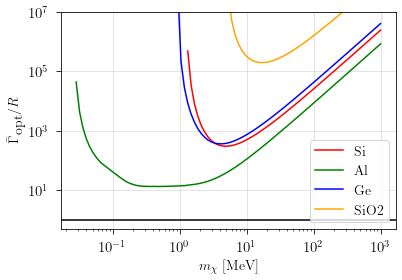

In [70]:
#GAMMA-RATIO USING target.R_electron
scalar = 916.667 #g_chi^2*g_e^2/e^2

#Gamma-opt
def gamma_opt(m_X):
    return 0.68/(4*math.pi)*m_X*v_0/c*scalar
'''
mX = np.logspace(4,9,100) #0.01 - 1000 MeV

R_Si = []
R_Al = []
R_Ge = []
R_SiO2 = []

step = 0
for x in mX:
    step = step + 1
    clear_output(wait=True)
    print('Working... (',step,'/',len(mX),')',sep='')

    Si.update_params(mX = x,mediator = 'massless')
    Al.update_params(mX = x,mediator = 'massless')
    Ge.update_params(mX = x,mediator = 'massless')
    SiO2.update_params(mX = x,mediator = 'massless')

    R_Si.append(gamma_opt(x)/Si.R_electron())
    R_Al.append(gamma_opt(x)/Al.R_electron(threshold=0.01,withscreening=True))
    R_Ge.append(gamma_opt(x)/Ge.R_electron())
    R_SiO2.append(gamma_opt(x)/SiO2.R_electron())

mX = mX/1e6

np.save('OurData/R Si.npy',R_Si)
np.save('OurData/R Ge.npy',R_Ge)
np.save('OurData/R Al.npy',R_Al)
np.save('OurData/R SiO2.npy',R_SiO2)
np.save('OurData/R mX.npy',mX)
'''
R_SI = np.load('OurData/R Si.npy')
R_Ge = np.load('OurData/R Ge.npy')
R_Al = np.load('OurData/R Al.npy')
R_SiO2 = np.load('OurData/R SiO2.npy')
mX = np.load('OurData/R mX.npy')

plt.loglog(mX,R_Si,color='red',label='Si')
plt.loglog(mX,R_Al,color='green',label='Al')
plt.loglog(mX,R_Ge,color='blue',label='Ge')
plt.loglog(mX,R_SiO2,color='orange',label='SiO2')
plt.axhline(1,0,1e4,color='black')
plt.xlabel(r'$m_\mathrm{\chi} \textrm{ [MeV]}$')
plt.ylabel(r'$\bar{\Gamma}_\textrm{opt}/R$')
plt.ylim([0.5,1e7])

plt.legend()
plt.grid(color='gainsboro')
plt.show

plt.savefig('figures/Gamma-ratio; R Si Al Ge SiO2; 100 steps.pdf',bbox_inches='tight')


In [3]:
#GAMMA-RAITO - SINGLE MATERIAL

#DM mass [eV]
m_X = 1e7
Si.update_params(mX = m_X,mediator = 'massless')
Ge.update_params(mX = m_X,mediator = 'massless')
Al.update_params(mX = m_X,mediator = 'massless')

#I(w,k) for massless mediator
def I(w,k):
      return (w/k*p1(w/k + k/(2*m_X)))/w

#w and k limits
w_min = 0
w_max = (v_max**2 * m_X / 2)
k_min = lambda w: (v_max*m_X - np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))
k_max = lambda w: (v_max*m_X + np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))

eVtoInvS = 1.5192674e15 # eV to 1/s
yeartosec = 86400 * 365
eVtoInvYr = eVtoInvS * yeartosec

#Solid angle
solid = 1/(2*np.pi**2)#1/(2*np.pi)**3

#Integral of I(w,k)ELF(w,k)
def integrand():
      f = lambda k, w: I(w,k)*Ge.elf(w,k,method='grid') / eVtoInvYr
      return dblquad(f,w_min,w_max,k_min,k_max)[0] * eVtoInvYr

#Gamma-opt
def gamma_opt(m_X):
      return 0.68/(4*math.pi)*m_X*v_0/c

#Gamma-bar 
def gamma_bar():
      return 2*integrand()*solid*c
'''
#Gamma-ratio plot
mX = np.logspace(5,9,50) #0.01 - 1000 MeV
gamma_ratio = []
step = 0
for x in mX:
      step = step + 1
      clear_output(wait=True)
      print('Working... (',step,'/',len(mX),')',sep='')

      m_X   = x
      w_min = 10
      w_max = (v_max**2 * m_X / 2)
      k_min = lambda w: (v_max*m_X - np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))
      k_max = lambda w: (v_max*m_X + np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))
      Ge.update_params(mX = m_X,mediator = 'massless')
      gamma_ratio.append(gamma_opt(x)/gamma_bar())

clear_output(wait=True)

mX = mX/1e6

plt.loglog(mX,gamma_ratio,color = 'red',label = 'Al (omega_min = 10 eV)')
plt.xlabel(r'$m_\chi$')
plt.ylabel(r'$\Gamma_{opt}/\overline{\Gamma}$')
plt.legend()
plt.show
plt.savefig('Ge wmin 10 eV.pdf',bbox_inches='tight')
'''
#----------------
#VARIABLE TESTING
#----------------
#print('For mX       =',m_X,'eV')
#print('---------------------------')
#print('Gamma-bar    =',gamma_bar())
#print('Gamma_opt    =',gamma_opt(m_X))
#print('integrand()  =',integrand())
#print('w_min        =',w_min)
#print('w_max        =',w_max)
#print('k_min(w_min) =',k_min(w_min))
#print('k_min(w_max) =',k_min(w_max))
#print('k_max(w_min) =',k_max(w_min))
#print('k_max(w_max) =',k_max(w_max))
#print('v_max*m_X    =',v_max*m_X)
#print('gamma_opt/gamma_bar = ', gamma_opt(m_X)/gamma_bar())


"\n#Gamma-ratio plot\nmX = np.logspace(5,9,50) #0.01 - 1000 MeV\ngamma_ratio = []\nstep = 0\nfor x in mX:\n      step = step + 1\n      clear_output(wait=True)\n      print('Working... (',step,'/',len(mX),')',sep='')\n\n      m_X   = x\n      w_min = 10\n      w_max = (v_max**2 * m_X / 2)\n      k_min = lambda w: (v_max*m_X - np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))\n      k_max = lambda w: (v_max*m_X + np.sqrt(v_max**2 * m_X**2 - 2 * m_X * w))\n      Ge.update_params(mX = m_X,mediator = 'massless')\n      gamma_ratio.append(gamma_opt(x)/gamma_bar())\n\nclear_output(wait=True)\n\nmX = mX/1e6\n\nplt.loglog(mX,gamma_ratio,color = 'red',label = 'Al (omega_min = 10 eV)')\nplt.xlabel(r'$m_\\chi$')\nplt.ylabel(r'$\\Gamma_{opt}/\\overline{\\Gamma}$')\nplt.legend()\nplt.show\nplt.savefig('Ge wmin 10 eV.pdf',bbox_inches='tight')\n"

c:\Users\beepp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


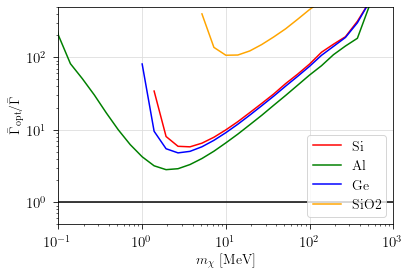

In [71]:
#GAMMA-RATIO - MULTIPLE MATERIALS

#Solid angle
solid = 1/(2*np.pi**2)#1/(2*np.pi)**3

#Gamma-opt
def gamma_opt(m_X):
      return 0.68/(4*math.pi)*m_X*v_0/c

#Integral of I(w,k)ELF(w,k)
def Si_integrand():
      f = lambda k, w: I(w,k)*Si.elf(w,k,method='grid') / eVtoInvYr
      return dblquad(f,w_min_si,w_max,k_min,k_max)[0] * eVtoInvYr

def Ge_integrand():
      f = lambda k, w: I(w,k)*Ge.elf(w,k,method='grid') / eVtoInvYr
      return dblquad(f,w_min_ge,w_max,k_min,k_max)[0] * eVtoInvYr

def Al_integrand():
      f = lambda k, w: I(w,k)*Al.elf(w,k,method='grid') / eVtoInvYr
      return dblquad(f,w_min_al,w_max,k_min,k_max)[0] * eVtoInvYr

def SiO2_integrand():
      f = lambda k, w: I(w,k)*SiO2.elf(w,k,method='grid') / eVtoInvYr
      return dblquad(f,w_min_sio2,w_max,k_min,k_max)[0] * eVtoInvYr

#Gamma-bar 
def Si_gamma_bar():
      return 2*Si_integrand()*solid*c

def Ge_gamma_bar():
      return 2*Ge_integrand()*solid*c

def Al_gamma_bar():
      return 2*Al_integrand()*solid*c

def SiO2_gamma_bar():
      return 2*SiO2_integrand()*solid*c

#Produces a vector gamma_opt/gamma_bar of all different mX
mX = np.logspace(2,9,50) #0.01 - 1000 MeV
'''
Si_gamma_ratio   = []
Al_gamma_ratio   = []
Ge_gamma_ratio   = []
SiO2_gamma_ratio = []

#Lower energy bounds [eV]
w_min_al   = .01
w_min_si   = 4.7
w_min_ge   = 3.6
w_min_sio2 = 16.8

step = 0
for x in mX:
      step = step + 1
      clear_output(wait=True)
      print('Working... (',step,'/',len(mX),')',sep='')
      
      m_chi = x
      w_max = (v_max**2 * m_chi / 2)
      k_min = lambda w: (v_max*m_chi - np.sqrt(v_max**2 * m_chi**2 - 2 * m_chi * w))
      k_max = lambda w: (v_max*m_chi + np.sqrt(v_max**2 * m_chi**2 - 2 * m_chi * w))

      Si.update_params(mX = m_chi,mediator = 'massless')
      Al.update_params(mX = m_chi,mediator = 'massless')
      Ge.update_params(mX = m_chi,mediator = 'massless')
      SiO2.update_params(mX = m_chi,mediator = 'massless')

      Si_gamma_ratio.append(gamma_opt(m_chi)/Si_gamma_bar())
      Al_gamma_ratio.append(gamma_opt(m_chi)/Al_gamma_bar())
      Ge_gamma_ratio.append(gamma_opt(m_chi)/Ge_gamma_bar())
      SiO2_gamma_ratio.append(gamma_opt(m_chi)/SiO2_gamma_bar())

clear_output(wait=True)
'''
mX = mX/1e6

'''
#Saving the data for future use
np.save('OurData/Si 4,7 eV.npy',Si_gamma_ratio)
np.save('OurData/Ge 3,6 eV.npy',Ge_gamma_ratio)
np.save('OurData/Al 10 meV.npy',Al_gamma_ratio)
np.save('OurData/SiO2 16.8 eV.npy',SiO2_gamma_ratio)
'''
#Loading data
#example = np.load(OurData/example.npy)
Si_ratio   = np.load('OurData/Si 4,7 eV.npy')
Ge_ratio   = np.load('OurData/Ge 3,6 eV.npy')
Al_ratio   = np.load('OurData/Al 10 meV.npy')
SiO2_ratio = np.load('OurData/SiO2 16,8 eV.npy')

#Plot
plt.loglog(mX,Si_ratio,color = 'red',label = 'Si')
plt.loglog(mX,Al_ratio,color = 'green',label = 'Al')
plt.loglog(mX,Ge_ratio,color = 'blue',label ='Ge')
plt.loglog(mX,SiO2_ratio,color = 'orange',label ='SiO2')

plt.xlabel(r'$m_\mathrm{\chi} \mathrm{\; [MeV]}$')
plt.ylabel(r'$\bar{\Gamma}_{\mathrm{opt}}/\bar{\Gamma}$')
plt.legend()
plt.grid(color='gainsboro')
plt.xlim([1e-1,1e3])
plt.ylim([.5e0,5e2])
plt.axhline(1,0,1e4,color='black')
plt.show
plt.savefig('figures/Gamma ratio; Gamma-bar; Si 4,7eV Ge 3,6eV Al 10 meV SiO2 8.4 eV; 50 steps.pdf',bbox_inches='tight')

In [ ]:
#ELF CONTOUR PLOT

wmin,wmax = 0,30
kmin,kmax = 500,4000

omega_vec = np.linspace(wmin,wmax,500)
k_vec     = np.linspace(kmin,kmax,500)

np.seterr(divide='ignore', invalid='ignore')
[K,W] = np.meshgrid(k_vec,omega_vec)
X = np.zeros((len(K), len(K[0])))
Y = np.zeros((len(K), len(K[0])))
contour_func = np.zeros((len(K), len(K[0])))

step = 0
for i in range(len(K)):
        step = step + 1
        clear_output(wait=True)
        print('Working... (',step,'/',len(K),')',sep='')
        for j in range(len(K[0])):
                contour_func[i][j] = Si.elf(W[i][j],K[i][j],method='Lindhard')
                X[i][j] = K[i][j]
                Y[i][j] = W[i][j] 

clear_output(wait=True)
plt.contourf(X,Y,contour_func,9)
plt.colorbar()
plt.show()